# Data Import

In [172]:
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from nltk.corpus import stopwords

from sklearn.model_selection import KFold
# import mse
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
# import linear regression
from sklearn.linear_model import LinearRegression
# set matplotlib style 
#import dummy regressor
from sklearn.dummy import DummyRegressor
plt.style.use('seaborn-whitegrid')

/var/folders/p9/8wv53k8n26dcpg3tjcvv6ll80000gn/T/ipykernel_66125/2255720124.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [173]:
corpus = pd.read_csv("..data/coffee_review.csv")
corpus.dropna(inplace=True)

In [174]:
corpus
# remove null values from the text
corpus = corpus[corpus['text'].notnull()]

In [175]:
corpus

,rating,title,text,price,review_date
0,96.0,Ethiopia Washed Guji Uraga Welichu,"Remarkably sweet, rich-toned, deeply floral. S...",$375/8 ounces,Nov 2022
1,94.0,Don Roger & Isabel’s Natural Fruit Symphony,"Cocoa-toned, bright and vibrant. Cocoa nib, pi...",Price: $19.00/175 grams,Nov 2022
2,95.0,Kenya Gitare AA TOP,"Sweetly bright, richly savory. Narcissus, pink...",$340/8 ounces,Nov 2022
3,93.0,Costa Rica Naranjo Danilo Salazar Arias,"Crisply sweet, brightly tart. Tamarind, pineap...",Price: $24.00/12 ounces,Nov 2022
4,95.0,Yemen Natural Sana’a Manakhah Ja’adi,"Deeply spice-toned, richly layered. Black curr...",$900/4 ounces,Nov 2022
...,...,...,...,...,...
6728,85.0,Skye’s Mountain Blend Decaf,Not nearly as dramatic as the Olympic mountain...,Price: NA,Jul 1998
6799,78.0,Mocha-Java Style,"Once again, a rather flat astringency, a sort ...",Price: NA,Jan 1998
6828,81.0,Dancing Goats Blend,"Simple but centered, a classically solid Espre...",Price: NA,Oct 1997
6835,75.0,Vesuvio Blend,"This remarkably light, self-effacing blend dis...",Price: NA,Oct 1997


In [176]:
# remove stop words
stop_words = stopwords.words('english')
#add and to stop words
stop_words.append('and')
corpus['text'] = corpus['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [177]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus['text'], corpus['rating'], test_size=0.2, random_state=42)
# to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


In [178]:
def get_ridge_model(c=1.0, bigrams=False):
    """Return a Ridge model pipeline with or without bigrams.
    Parameters
    ----------
    alpha : float
        The regularization strength of the Ridge regressor.
    bigrams : bool
        Whether to include bigrams in the model.
    """
    if bigrams:
        ngram_range = (2, 2)
    else:
        ngram_range = (1, 1)
    return Pipeline([
        ('vect', TfidfVectorizer(ngram_range=ngram_range)),
        ('clf', Ridge(alpha=1/(2*c), fit_intercept=True))
    ])

In [179]:
def get_linear_regresssion(bigrams = False, vectorizer = "TfIDF"):
    """Return a Linear Regression model pipeline with or without bigrams.
    Parameters
    ----------
    bigrams : bool
        Whether to include bigrams in the model.
    vectorizer : str
        The vectorizer to use.
    """
    
    if bigrams:
        ngram_range = (2, 2)
    else:
        ngram_range = (1, 1)
    if vectorizer == "TfIDF":
        return Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngram_range)),
            ('clf', LinearRegression())
        ])
    elif vectorizer == "Count":
        return Pipeline([
            ('vect', CountVectorizer(ngram_range=ngram_range)),
            ('clf', LinearRegression(fit_intercept=True))
        ])

In [180]:
def get_knn_model(n_neighbors=5, bigrams=False):
    """Return a KNN model pipeline with or without bigrams.
    Parameters
    ----------
    n_neighbors : int
        The number of neighbors to use by default for kneighbors queries.
    bigrams : bool
        Whether to include bigrams in the model.
    """
    if bigrams:
        ngram_range = (2, 2)
    else:
        ngram_range = (1, 1)
    return Pipeline([
        ('vect', TfidfVectorizer(ngram_range=ngram_range)),
        ('clf', KNeighborsRegressor(n_neighbors=n_neighbors))
    ])

In [203]:
def get_error_plot(models, values, x_train, y_train, title = '', x_label = ''):
    """Return a plot of the error for each model.
    Parameters
    ----------
    models : list
        A list of models.
    values : list
        A list of values to test.
    x_train : array
        The training data.
    y_train : array
        The training labels.
    title : str
        The title of the plot.
    x_label : str
        The label of the x-axis.
    """
    # do k-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mean_errors = []
    std_errors = []
    best_model = None
    best_score = 100
    best_value = None
    for i, model in enumerate(models):
        errors = []
        for train_index, test_index in kf.split(x_train):
            X_train, X_val = x_train[train_index], x_train[test_index]
            Y_train, Y_val = y_train[train_index], y_train[test_index]
            model.fit(X_train, Y_train)
            error = mean_squared_error(Y_val, model.predict(X_val))
            errors.append(error)
        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))
        if np.mean(errors) < best_score:
            best_model = model
            best_score = np.mean(errors)
            best_value = values[i]
    fig, ax = plt.subplots(1, 1)
    # error plot
    ax.errorbar(
        values,
        mean_errors,
        yerr=std_errors,
        label="validation",
        capsize=5,
        capthick=2,
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel("mean squared error")
    ax.set_title(title)
    #set position of legend
    ax.legend(loc='upper right')
    print("Best value: ", best_value)
    return fig,best_model



In [204]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
k_values = [1, 11, 21, 51, 101, 201]

In [205]:
knn_models_ug = [get_knn_model(k) for k in k_values]
ridge_models_ug = [get_ridge_model(c) for c in c_values]
knn_models_bg = [get_knn_model(k, bigrams=True) for k in k_values]
ridge_models_bg = [get_ridge_model(c, bigrams=True) for c in c_values]

Best value:  11


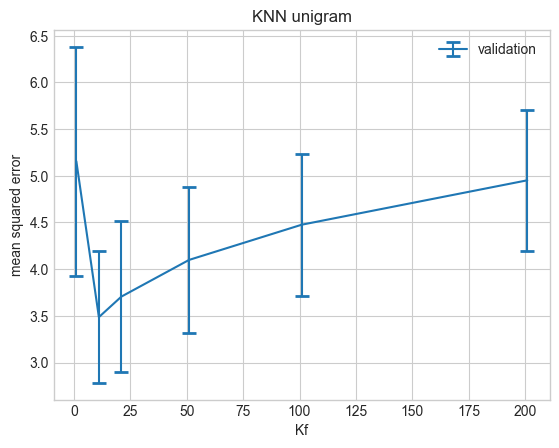

In [206]:
# plot error vs hyperparameter value
erroplot_knn_ug = get_error_plot(knn_models_ug, k_values, X_train, y_train, title='KNN unigram', x_label='Kf')
# save plot tightly
erroplot_knn_ug[0].savefig('../plots/knn_ug.png', dpi=300, bbox_inches='tight')
best_knn_ug = erroplot_knn_ug[1]

Best value:  1


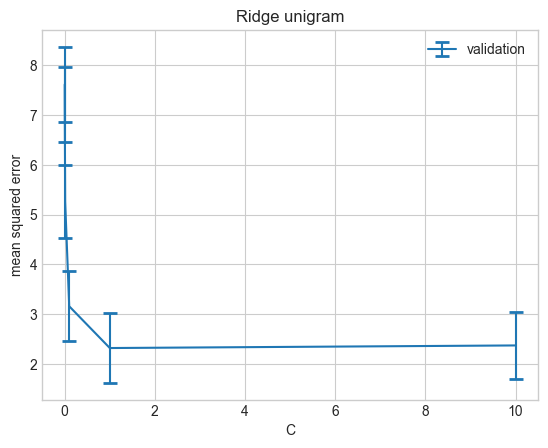

In [207]:
# plot error vs hyperparameter value
erroplot_ridge_ug = get_error_plot(ridge_models_ug, c_values, X_train, y_train, title='Ridge unigram', x_label='C')
# save plot tightly
erroplot_ridge_ug[0].savefig('../plots/ridge_ug.png', dpi=300, bbox_inches='tight')
best_ridge_ug = erroplot_ridge_ug[1]


Best value:  11


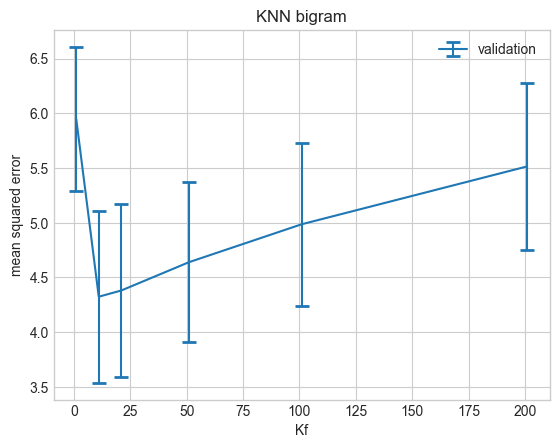

In [208]:
# plot error vs hyperparameter value
erroplot_knn_bg = get_error_plot(knn_models_bg, k_values, X_train, y_train, title='KNN bigram', x_label='Kf')
# save plot tightly
erroplot_knn_bg[0].savefig('../plots/knn_bg.png', dpi=300, bbox_inches='tight')
best_knn_bg = erroplot_knn_bg[1]



Best value:  10


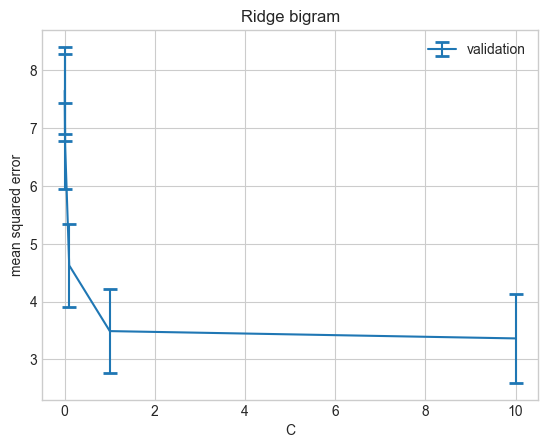

In [209]:
# ridge bigram
erroplot_ridge_bg = get_error_plot(ridge_models_bg, c_values, X_train, y_train, title='Ridge bigram', x_label='C')
# save plot tightly
erroplot_ridge_bg[0].savefig('../plots/ridge_bg.png', dpi=300, bbox_inches='tight')
best_ridge_bg = erroplot_ridge_bg[1]

In [210]:
# get linear regression models
lr_ug = get_linear_regresssion()
lr_bg = get_linear_regresssion(bigrams=True)
# for coount vectorizer
lr_ug_count = get_linear_regresssion(vectorizer="Count")
lr_bg_count = get_linear_regresssion(bigrams=True, vectorizer="Count")

In [211]:
# fit each model on the training data
lr_ug.fit(X_train, y_train)
lr_bg.fit(X_train, y_train)
lr_ug_count.fit(X_train, y_train)
lr_bg_count.fit(X_train, y_train)
# same for ridge and knn
best_ridge_ug.fit(X_train, y_train)
best_ridge_bg.fit(X_train, y_train)
best_knn_ug.fit(X_train, y_train)
best_knn_bg.fit(X_train, y_train)


Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(2, 2))),
                ('clf', KNeighborsRegressor(n_neighbors=11))])

In [212]:
# dummy regressor
dummy = DummyRegressor(strategy='mean')

In [213]:
models = [
    ('Dummy', dummy),
    ('Linear Regression unigram BoW', lr_ug_count),
    ('Linear Regression bigram BoW', lr_bg_count),
    ('Linear Regression unigram TfIdF', lr_ug),
    ('Linear Regression bigram TfIdF', lr_bg),
    ('Ridge unigram TfIdF', best_ridge_ug),
    ('Ridge bigram TfIdF', best_ridge_bg),
    ('KNN unigram', best_knn_ug),
    ('KNN bigram', best_knn_bg),

]

In [242]:
#score each model and put results in a dataframe
results = []
for name, model in models:
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    mae = mean_absolute_error(y_test, model.predict(X_test))
    results.append([name, mse, mae])

results = pd.DataFrame(results, columns=['Model', 'MSE', 'MAE'])

In [243]:
results

,Model,MSE,MAE
0,Dummy,6.623949,1.644000
1,Linear Regression unigram BoW,3.794380,1.276625
2,Linear Regression bigram BoW,2.979524,1.077102
3,Linear Regression unigram TfIdF,2.990463,1.192310
4,Linear Regression bigram TfIdF,2.580543,1.046458
5,Ridge unigram TfIdF,1.507774,0.864445
6,Ridge bigram TfIdF,2.581587,1.034173
7,KNN unigram,2.277129,1.038206
8,KNN bigram,3.472061,1.110513


In [234]:
feature_names = best_ridge_bg.named_steps['vect'].get_feature_names()
coefs_with_fns = sorted(
    zip(best_ridge_bg.named_steps['clf'].coef_, feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
df = pd.DataFrame()
for (coef_1, fn_1), (coef_2, fn_2) in top:
    df = df.append({"coef_1": coef_1, "fn_1": fn_1,
                   "coef_2": coef_2, "fn_2": fn_2}, ignore_index=True)


/Users/christopherlohse/Library/Caches/pypoetry/virtualenvs/group-project-zbs9HXug-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/p9/8wv53k8n26dcpg3tjcvv6ll80000gn/T/ipykernel_66125/3263017866.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"coef_1": coef_1, "fn_1": fn_1,
/var/folders/p9/8wv53k8n26dcpg3tjcvv6ll80000gn/T/ipykernel_66125/3263017866.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"coef_1": coef_1, "fn_1": fn_1,
/var/folders/p9/8wv53k8n26dcpg3tjcvv6ll80000gn/T/ipykernel_66125/3263017866.py:7: FutureWarning: The frame.ap

/var/folders/p9/8wv53k8n26dcpg3tjcvv6ll80000gn/T/ipykernel_66125/754425757.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


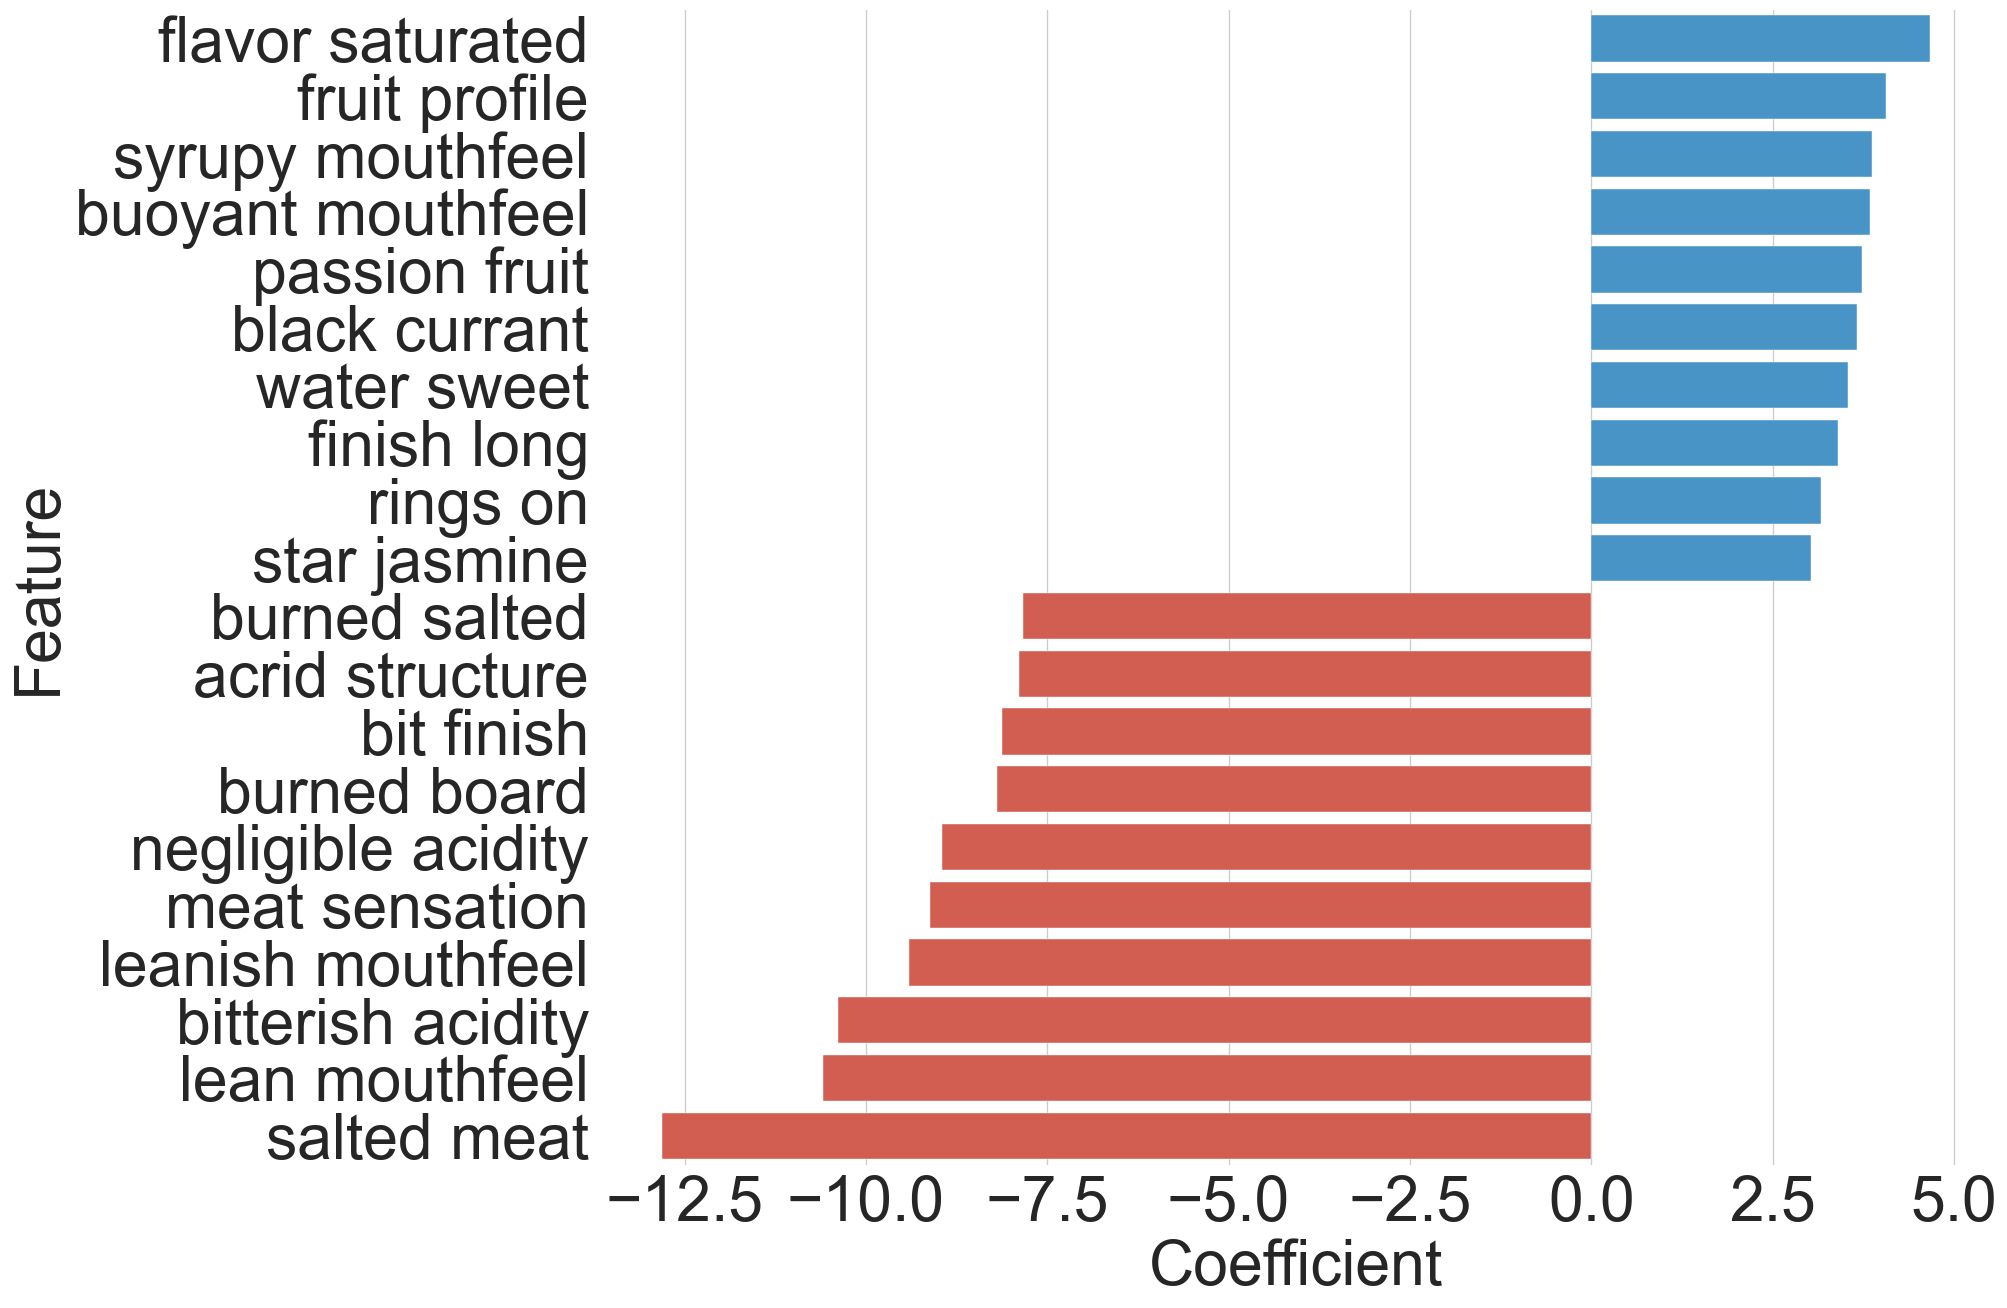

<Figure size 800x550 with 0 Axes>

In [236]:
# make a barplot with the most important features color positive and negative in blue and red in the same plot
# !pip install seaborn

import seaborn as sns
plt.rc('font', size=30)
# change plot size
plt.figure(figsize=(18, 15))
# set sns style
# set matplotlib style
plt.style.use("seaborn")
sns.set_style("whitegrid")
#sns.set(style="whitegrid")
values_neg = list(df["fn_1"].values)
values_neg.reverse()
coef_neg = list(df["coef_1"].values)
coef_neg.reverse()
sns.set_color_codes("pastel")
x = list(df["fn_2"].values) + values_neg
y = list(df["coef_2"].values) + coef_neg
# colors = ["red" if y_ < 0 else "blue" for y_ in y]
# set pastel  solor manurally pastel red and blue for negative and positive
colors = ["#e74c3c" if y_ < 0 else "#3498db" for y_ in y]
# vertical barplot
sns.barplot(x=y, y=x, palette=colors)
# rotate the labels
# add labels
plt.xlabel("Coefficient", fontsize=45)
plt.ylabel("Feature", fontsize=45)
# bigger text for axis labels
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# show the seaborn plot
plt.show()

# save plot tightly
